Zadanie 4 (7 pkt)

Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

Implementacja funkcji entropii - 0.5 pkt
Implementacja funkcji entropii zbioru - 0.5 pkt
Implementacja funkcji information gain - 0.5 pkt
Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - 4 pkt
Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - 1.5 pkt

In [389]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

In [390]:
def entropy_func(class_count, num_samples):
    probability = class_count/num_samples
    return -probability * math.log2(probability) if probability > 0 else 0


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return len(self.group_classes)

    def group_entropy(self):
        counter = Counter(self.group_classes)
        return sum(entropy_func(class_count, len(self)) for class_count in counter.values())


class Node:
    def __init__(self, split_feature=None, split_val=None, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data):
        if self.child_node_a is None and self.child_node_b is None:
            return self.val
        elif data[self.split_feature] <= [self.split_val]:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)

class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None
    
    @staticmethod
    def get_split_entropy(group_a, group_b):
        total = len(group_a) + len(group_b)
        child_a_parameter = len(group_a) / total
        child_b_parameter = len(group_b) / total
        return child_a_parameter * group_a.group_entropy() + child_b_parameter * group_b.group_entropy()

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        parent_entropy = parent_group.group_entropy()
        return parent_entropy - self.get_split_entropy(child_group_a, child_group_b)

    def get_best_feature_split(self, feature_values, classes):
        best_information_gain = float('-inf')
        best_split_value = None

        for value in set(feature_values):
            group_a = Group([c for v, c in zip(feature_values, classes) if v <= value])
            group_b = Group([c for v, c in zip(feature_values, classes) if v > value])

            information_gain = self.get_information_gain(Group(classes), group_a, group_b)

            if information_gain > best_information_gain:
                best_information_gain = information_gain
                best_split_value = value

        return best_split_value, best_information_gain

    def get_best_split(self, data, classes):
        best_feature = None
        best_split_value = None
        best_information_gain = float('-inf')

        for feature_index in range(len(data[0])):
            feature_values = [row[feature_index] for row in data]
            split_value, information_gain = self.get_best_feature_split(feature_values, classes)

            if information_gain > best_information_gain:
                best_information_gain = information_gain
                best_feature = feature_index
                best_split_value = split_value

        return best_feature, best_split_value

    def build_tree(self, data, classes, depth=0):
        if depth >= self.max_depth or len(set(classes)) == 1:
            return Node(val=Counter(classes).most_common(1)[0][0])

        best_feature, best_split_value = self.get_best_split(data, classes)

        group_a_indices = [i for i, val in enumerate(data[:, best_feature]) if val <= best_split_value]
        group_b_indices = [i for i in range(len(data)) if i not in group_a_indices]

        node = Node(split_feature=best_feature, split_val=best_split_value, depth=depth)

        node.child_node_a = self.build_tree(data[group_a_indices], classes[group_a_indices], depth + 1)
        node.child_node_b = self.build_tree(data[group_b_indices], classes[group_b_indices], depth + 1)

        return node

    def start_building_tree(self, data, classes):
        self.tree = self.build_tree(data, classes)

    def predict(self, data):
        return self.tree.predict(data)
    
    def print_tree(self):
        def print_node(node: Node, indent=""):
            if node.child_node_a is None and node.child_node_b is None:
                print(indent + f"Answer is {node.val}")
            else:
                print(indent + f"Split, feature {node.split_feature}, value -> {node.split_val}")

                print(indent + " -> " + f"(A)")
                print_node(node.child_node_a, indent + "      ")
                
                print(indent + " -> " + f"(B)")
                print_node(node.child_node_b, indent + "      ")
        
        print_node(self.tree)


In [391]:
def evaluate_accuracy(dc, test_data, test_classes):
        correct_predictions = 0
        total_samples = len(test_data)

        for data_point, true_class in zip(test_data, test_classes):
            predicted_class = dc.predict(data_point)

            if true_class == predicted_class:
                correct_predictions += 1

            print(f"True Class: {true_class}, Predicted Class: {predicted_class}")

        accuracy = correct_predictions / total_samples
        print(f"Accuracy: {accuracy * 100:.2f}%")

Eksperytment dla zadanych danych testowych.

In [392]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
tree = DecisionTreeClassifier(3)
tree.start_building_tree(x_train, y_train)
# tree.print_tree()
evaluate_accuracy(tree, x_test, y_test)


True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
Accuracy: 93.33%


Wynik ewaluacji przeprowadzano dla zwiększonego parametru test_size. Test size określa jaka cześć danych zostań przeznaczona do utworzenia danych testowych. Pozostałe dane są wykorzystywane do uczenia algorytmu. Zmienna random_state natomiast określa losować w wyborze danych testowych.

Wyniki dla różnych wartości test_size

In [393]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=123)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 1
True Class: 0, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0,

In [394]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=123)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0,

In [395]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=123)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
Accuracy: 87.50%


In [396]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, random_state=123)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
Accuracy: 50.00%


Obserwacja: Przy zwiększeniu wielkości danych testujących (i tym samym zmniejszeniu danych trenujących) otrzymujemy mniejszą dokładność w prognozie wyników dla danych testowych. Mniejsza ilość danych testowych będzie negatywnie wpływała na przewidywanie algorytmu. 

Wyniki dla różnych wartości random_state

In [397]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
Accuracy: 93.33%


In [398]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=3)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
Accuracy: 100.00%


In [399]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1000)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
Accuracy: 86.67%


In [400]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=None)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
Accuracy: 100.00%


Wyniki dla różnych głębokości

In [401]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
tree = DecisionTreeClassifier(max_depth=1)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 2, Predicted Class: 1
Accuracy: 60.00%


In [402]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
tree = DecisionTreeClassifier(max_depth=3)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
Accuracy: 93.33%


In [403]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
tree = DecisionTreeClassifier(max_depth=5)
tree.start_building_tree(x_train, y_train)
evaluate_accuracy(tree, x_test, y_test)

True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
Accuracy: 86.67%


Obeserwacje: Możemy zauważyć wzrost dokładności predykcji dla zwiększającej się głębokości. Większa głębokość dała nam możliwość wytworzenia dokłądniej wytrenowanego modelu, który lepiej jest w stanie przewidzieć wyniki dla danych testowych. Dzieje się tak do momentu natrafienia na głębokość, która przetrenowuje dane. Wtedy dokładność predykcji spada.

In [404]:
def get_accuracy(y_pred, y_test):
    return sum([1 if y_pred[i] == y_test[i] else 0 for i in range(len(y_pred))]) / len(y_pred)

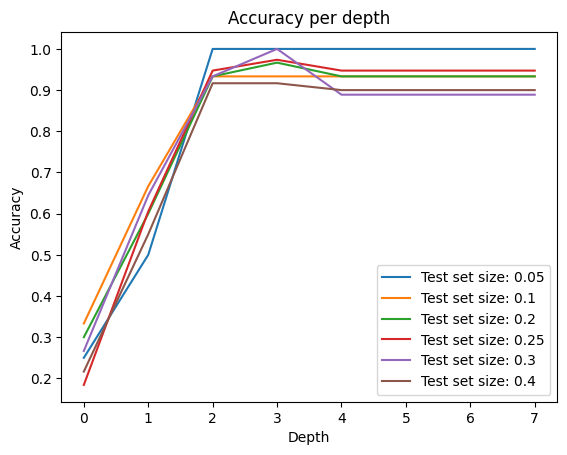

In [405]:
fig, ax = plt.subplots()

max_depths = range(8)
test_sizes = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4]

for test_size in test_sizes:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=None)
    accuracies = []
    for depth in max_depths:
        tree = DecisionTreeClassifier(depth)
        tree.start_building_tree(x_train, y_train)

        predictions = [tree.predict(sample) for sample, gt in zip(x_test, y_test)] 
        accuracy = get_accuracy(predictions, y_test)
        accuracies.append(accuracy)

    ax.plot(max_depths, accuracies, label=f"Test set size: {test_size}")

plt.title("Accuracy per depth")

ax.set_xlabel("Depth")
ax.set_ylabel("Accuracy")

plt.legend()
plt.show()

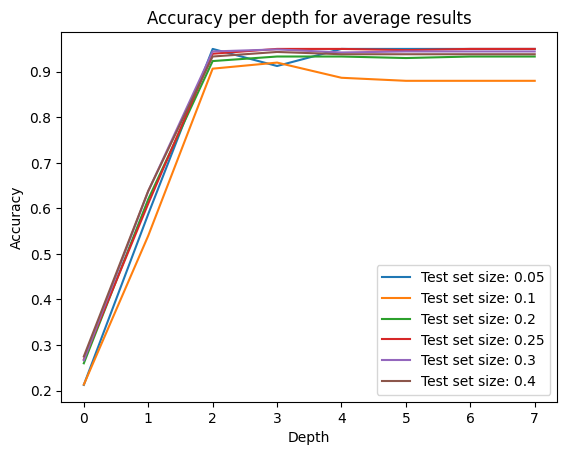

In [406]:
probes = 10
fig, ax = plt.subplots()
max_depths = range(8)
test_sizes = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4]

for test_size in test_sizes:
    accuracies = [0 for _ in range(len(max_depths))]
    for probe in range(probes):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=None)
        for depth in max_depths:
            tree = DecisionTreeClassifier(depth)
            tree.start_building_tree(x_train, y_train)

            predictions = [tree.predict(sample) for sample, gt in zip(x_test, y_test)] 
            accuracy = get_accuracy(predictions, y_test)
            accuracies[depth] += accuracy
    
    accuracies = [accuracy / probes for accuracy in accuracies]
    ax.plot(max_depths, accuracies, label=f"Test set size: {test_size}")

plt.title("Accuracy per depth for average results")

ax.set_xlabel("Depth")
ax.set_ylabel("Accuracy")

plt.legend()
plt.show()